# Per-Asset Voltage Compliance Planning Tool: Machine Learning Decision Product (Tap change vs STATCOM)

This notebook operationalises a repeatable, per-asset machine learning workflow to decide whether intervention is needed and which option is most cost-effective under PV injections and load variability.

## What this produces (per asset)
- Observed compliance (Year-1 control vs Year-2 after): annualised hard breach hours (outside 216-253 V) and near-breach risk hours (within `V_RISK_BUFFER` of limits), with 95% CIs (confidence intervals).
- Counterfactual baseline for Year-2: a machine learning model trained on Year-1 relationships between operating conditions (P/Q imports/exports + time) and risk, then applied to Year-2 conditions to estimate what would likely have happened without the intervention.
- Intervention benefit: avoided near-breach risk (hours/year) with uncertainty.
- Decision support + economics: a consistent comparison of options using capex per avoided risk-hour and a benefit-vs-cost view. A residual-risk check flags cases where reconductoring is still required to meet planning targets.

## How this scales across assets
The data-driven decision support layer can be run per feeder/transformer/zone by swapping the input datasets. Outputs can be aggregated into a fleet-level prioritisation dashboard (rank by residual risk, avoided risk, $/risk-hour, etc.).

In [ ]:
# Voltage compliance limits (Australian LV)
V_UPPER = 253
V_LOWER = 216

# Near-breach "risk" definition:
# We treat voltages within ±V_RISK_BUFFER of a limit as "at risk".
# risk_score ∈ [0,1] increases linearly as voltage approaches the limit.
V_RISK_BUFFER = 6  # volts

# Planning threshold: annual near-breach minutes above this are considered
# "material risk"
RISK_TARGET_MIN_PER_YEAR = 150 * 60  # minutes per year

# Costs (capex only since no opex for Tap change, STATCOM)
TAP_CAPEX = 1_000
STATCOM_CAPEX = 75_000
RECONDUCT_COST_PER_KM = 210_000

# Reconductoring scenario length (planning input)
RECONDUCTOR_KM = 1
RECONDUCT_COST = RECONDUCT_COST_PER_KM * RECONDUCTOR_KM

# Bootstrap settings (day-block uncertainty)
# Each bootstrap resample represents an alternative year-equivalent realisation
# consistent with the observed data, allowing uncertainty bounds to be estimated
# without parametric assumptions.
N_BOOT = 300

---
## Input data (per asset)

Each dataset should contain 5-minute (or regular) time series with:
- `dateTime` timestamp column (parsed in a deterministic way)
- voltage column(s) used to compute compliance and risk
- operating condition features for counterfactual modelling:
  - `activePowerImport`, `activePowerExport`
  - `reactivePowerImport`, `reactivePowerExport`
  - derived `Q_net` (import - export) and time features (`hour`, `dayofweek`, …)

For **PV/load variability:** if you add higher-frequency drivers (net export ramps, rolling volatility), the counterfactual model will better capture PV injection swings and load fluctuation regimes.

In [ ]:
# @title
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

plt.rcParams.update({
    # Resolution
    "figure.dpi": 120,
    "savefig.dpi": 150,

    # Figure sizing defaults (smaller & tighter)
    "figure.figsize": (6.0, 3.6),

    # Fonts
    "font.size": 8.5,
    "axes.titlesize": 11.5,
    "axes.labelsize": 9.5,
    "legend.fontsize": 8.5,
    "xtick.labelsize": 8.5,
    "ytick.labelsize": 8.5,

    # Grid (lighter, less visual noise)
    "axes.grid": True,
    "grid.alpha": 0.18,
    "grid.linestyle": "--",

    # Spacing
    "figure.autolayout": True,
})

MINUTES_PER_YEAR = 365 * 24 * 60

In [ ]:
# @title
# Helper functions
def parse_datetime_column(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Parse datetimes robustly across exports (deterministic)."""
    s = df[col].astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    formats = [
        # 4-digit year + 12h + seconds + AM/PM
        "%d-%m-%Y %I:%M:%S %p",
        "%d-%m-%Y %I:%M %p",
        # 4-digit year + 24h
        "%d-%m-%Y %H:%M:%S",
        "%d-%m-%Y %H:%M",
        # 2-digit year + 24h
        "%d-%m-%y %H:%M:%S",
        "%d-%m-%y %H:%M",
        # 2-digit year + 12h + AM/PM
        "%d-%m-%y %I:%M:%S %p",
        "%d-%m-%y %I:%M %p",
    ]

    dt = pd.Series(pd.NaT, index=s.index)
    for fmt in formats:
        parsed = pd.to_datetime(s, format=fmt, errors="coerce", cache=True)
        dt = dt.fillna(parsed)

    if dt.isna().any():
        n_bad = int(dt.isna().sum())
        bad_examples = s[dt.isna()].head(10).tolist()
        raise ValueError(
            f"{n_bad} rows have invalid {col} format. "
            f"Example bad values: {bad_examples}"
        )

    df = df.copy()
    df[col] = dt
    return df



def add_interval_minutes(df: pd.DataFrame, dt_col: str) -> pd.DataFrame:
    """Compute monitored interval (minutes) per row from timestamp deltas, robust to gaps."""
    d = df.sort_values(dt_col).copy()
    delta = d[dt_col].diff().dt.total_seconds() / 60.0

    # Infer nominal interval from median of positive deltas
    nominal = float(delta[delta > 0].median()) if (delta > 0).any() else 5.0
    if not np.isfinite(nominal) or nominal <= 0:
        nominal = 5.0

    # Clamp large gaps (treat gap as unmonitored); use nominal for first row
    interval = delta.fillna(nominal)
    interval = interval.clip(lower=0, upper=nominal * 3)  # cap at 3x nominal

    d["interval_min"] = interval
    d["interval_min_inferred"] = nominal
    return d


def add_time_features(df: pd.DataFrame, dt_col: str) -> pd.DataFrame:
    d = df.copy()
    ts = d[dt_col]
    d["hour"] = ts.dt.hour
    d["dow"] = ts.dt.dayofweek
    d["dayofweek"] = d["dow"]
    d["is_weekend"] = (d["dow"] >= 5).astype(int)
    d["month"] = ts.dt.month
    return d


def compute_risk_and_violation_minutes(df: pd.DataFrame) -> pd.DataFrame:
    """Create both hard-breach minutes and near-breach (risk) minutes.

    - Hard breach uses *average* voltage per sample (conservative vs min/max spikes).
    - Risk minutes counts time spent within V_RISK_BUFFER of either limit.
      This avoids '0 minutes' after an intervention while still reflecting proximity to limits.
    """
    d = df.copy()

    # Hard breaches (binary)
    d["over_flag"] = (d["voltage"] > V_UPPER).astype(int)
    d["under_flag"] = (d["voltage"] < V_LOWER).astype(int)
    d["violation_flag"] = ((d["over_flag"] == 1) | (d["under_flag"] == 1)).astype(int)
    d["ViolationMinutes"] = d["violation_flag"] * d["interval_min"]

    # Near-breach risk (continuous 0..1)
    buf = float(V_RISK_BUFFER)
    # distance to upper limit when below it (0 at/above limit)
    dist_to_upper = np.maximum(0.0, V_UPPER - d["voltage"].astype(float))
    # distance to lower limit when above it (0 at/below limit)
    dist_to_lower = np.maximum(0.0, d["voltage"].astype(float) - V_LOWER)

    risk_over = np.maximum(0.0, 1.0 - dist_to_upper / buf)
    risk_under = np.maximum(0.0, 1.0 - dist_to_lower / buf)

    d["risk_score"] = np.maximum(risk_over, risk_under)
    d["RiskMinutes"] = d["risk_score"] * d["interval_min"]

    return d


def summarize_observed(df: pd.DataFrame, name: str) -> dict:
    monitored = float(df["interval_min"].sum())
    viol = float(df["ViolationMinutes"].sum())
    risk = float(df["RiskMinutes"].sum())

    annual_viol = (viol / monitored) * MINUTES_PER_YEAR if monitored > 0 else np.nan
    annual_risk = (risk / monitored) * MINUTES_PER_YEAR if monitored > 0 else np.nan

    return {
        "dataset": name,
        "samples": int(len(df)),
        "interval_min_inferred": float(df["interval_min_inferred"].iloc[0]),
        "monitored_minutes": monitored,
        "total_violation_minutes": viol,
        "total_risk_minutes": risk,
        "Pr_violation": float(df["violation_flag"].mean()),
        "annual_violation_minutes_est": annual_viol,
        "annual_risk_minutes_est": annual_risk,
    }


def calibrate_risk_uplift(df_y1: pd.DataFrame) -> float:
    """Map predicted breach probability -> expected risk minutes.

    Year-1 gives us both:
      - observed annual violation minutes
      - observed annual risk minutes

    We use their ratio as an empirical uplift factor so counterfactual Year-2 isn't unrealistically spiky.
    """
    s = summarize_observed(df_y1, "y1")
    if not np.isfinite(s["annual_violation_minutes_est"]) or s["annual_violation_minutes_est"] <= 0:
        return 1.0
    return float(s["annual_risk_minutes_est"] / s["annual_violation_minutes_est"])



def day_block_bootstrap_annual_minutes(df: pd.DataFrame, minutes_col: str, n_boot: int = 200, seed: int = 42):
    """Fast day-block bootstrap CI for annualised minutes, using pre-aggregated daily totals."""
    d = df.copy()
    d["date"] = d[DATETIME_COL].dt.date

    daily = d.groupby("date").agg(
        day_minutes=(minutes_col, "sum"),
        day_monitored=("interval_min", "sum"),
    )

    v = daily["day_minutes"].to_numpy()
    m = daily["day_monitored"].to_numpy()

    mask = m > 0
    v, m = v[mask], m[mask]
    n_days = len(v)
    if n_days < 5:
        return (np.nan, np.nan)

    rng = np.random.default_rng(seed)
    idx = rng.integers(0, n_days, size=(n_boot, n_days))
    v_sum = v[idx].sum(axis=1)
    m_sum = m[idx].sum(axis=1)
    annual = (v_sum / m_sum) * MINUTES_PER_YEAR
    lo, hi = np.percentile(annual, [2.5, 97.5])
    return float(lo), float(hi)


# Formatting helpers
def fmt_minutes(x: float) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "—"
    if x < 60:
        return f"{x:,.0f} min"
    hr = x/60.0
    if hr < 48:
        return f"{hr:,.1f} h"
    days = hr/24.0
    return f"{days:,.1f} d"

def fmt_currency(x: float) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "—"
    return f"${x:,.0f}"

from IPython.display import display, Markdown, HTML

def callout(title: str, lines: list[str], kind: str = "info"):
    # kind: info / success / warning
    palette = {
        "info":    "#1f77b4",
        "success": "#2ca02c",
        "warning": "#d62728",
    }
    color = palette.get(kind, "#1f77b4")

    bullets = "".join(f"<li>{l}</li>" for l in lines)

    html = f"""
    <div style="
        border-left: 6px solid {color};
        padding: 12px 14px;
        margin: 12px 0;
        color: inherit;
        border-radius: 4px;
    ">
        <div style="
            font-weight: 700;
            margin-bottom: 6px;
            color: {color};
        ">
            {title}
        </div>
        <ul style="
            margin: 0 0 0 18px;
            padding: 0;
        ">
            {bullets}
        </ul>
    </div>
    """
    display(HTML(html))


In [ ]:
# @title
# Load all datasets
dfs = {}
summaries = []

for key, path in DATASETS.items():
    df = pd.read_csv(path)

    df = parse_datetime_column(df, DATETIME_COL)
    df = add_interval_minutes(df, DATETIME_COL)
    df = add_time_features(df, DATETIME_COL)
    df = compute_risk_and_violation_minutes(df)
    dfs[key] = df
    summaries.append(summarize_observed(df, key))

summary_df = pd.DataFrame(summaries).sort_values("dataset")

In [ ]:
# @title
pretty = summary_df.copy()

# Rename columns
pretty = pretty.rename(columns={
    "dataset": "Dataset",
    "monitored_minutes": "Monitored (min)",
    "annual_violation_minutes_est": "Annual violation (min, est.)",
    "annual_risk_minutes_est": "Annual near-breach risk (min, est.)",
})

# Convert everything to hours
pretty["Monitored (days)"] = pretty["Monitored (min)"] / (60.0 * 24.0)

pretty["Annual violation (hours, est.)"] = pretty["Annual violation (min, est.)"] / 60.0
pretty["Annual near-breach risk (hours, est.)"] = pretty["Annual near-breach risk (min, est.)"] / 60.0

# Final column order (observed violations removed)
col_order = [
    "Dataset",
    "Monitored (days)",
    "Annual violation (hours, est.)",
    "Annual near-breach risk (hours, est.)",
]

pretty = pretty[col_order]

# Styling
def highlight_smallest(s):
    is_min = s == s.min()
    return [
        "font-weight: 700; background-color: rgba(0, 200, 0, 0.12)" if v else ""
        for v in is_min
    ]

styled = (
    pretty.style
    .format({
        "Monitored (days)": "{:,.1f}",
        "Annual violation (hours, est.)": "{:,.2f}",
        "Annual near-breach risk (hours, est.)": "{:,.2f}",
    })
    .set_properties(**{"text-align": "left"})
    .set_table_styles([
        {"selector": "th", "props": [("font-weight", "700"), ("text-align", "left")]},
        {"selector": "td", "props": [("padding", "6px 10px")]},
    ])
    .bar(subset=["Annual violation (hours, est.)"], axis=0)
    .bar(subset=["Annual near-breach risk (hours, est.)"], axis=0)
    .apply(highlight_smallest, subset=["Annual violation (hours, est.)"])
    .apply(highlight_smallest, subset=["Annual near-breach risk (hours, est.)"])
    .hide(axis="index")
)

styled


Dataset,Monitored (days),"Annual violation (hours, est.)","Annual near-breach risk (hours, est.)"
stat_y1,343.8,5.31,433.23
stat_y2,377.3,2.82,6.09
tap_y1,349.0,497.83,"4,168.87"
tap_y2,373.8,0.00,113.48


In [ ]:
# @title
# Key observation: observed compliance (before vs after)
def _get(df, name, col):
    return float(df.loc[df["dataset"]==name, col].iloc[0])

# Hard breaches (outside limits)
tap_y1_v = _get(summary_df, "tap_y1", "annual_violation_minutes_est")
tap_y2_v = _get(summary_df, "tap_y2", "annual_violation_minutes_est")
stat_y1_v = _get(summary_df, "stat_y1", "annual_violation_minutes_est")
stat_y2_v = _get(summary_df, "stat_y2", "annual_violation_minutes_est")

# Near-breach risk (buffer zone near limits) — more stable planning signal
tap_y1_r = _get(summary_df, "tap_y1", "annual_risk_minutes_est")
tap_y2_r = _get(summary_df, "tap_y2", "annual_risk_minutes_est")
stat_y1_r = _get(summary_df, "stat_y1", "annual_risk_minutes_est")
stat_y2_r = _get(summary_df, "stat_y2", "annual_risk_minutes_est")

callout(
    "Observed Year-1 vs Year-2 (observed compliance outcomes)",
    [
        (
            f"Tap change: "
            f"Annualised hard-breach duration reduces from {fmt_minutes(tap_y1_v)} in Year-1 "
            f"to {fmt_minutes(tap_y2_v)} in Year-2, indicating elimination of observed statutory "
            f"limit exceedances over the monitored Year-2 period. "
            f"Consistently, annualised near-breach risk decreases from {fmt_minutes(tap_y1_r)} "
            f"to {fmt_minutes(tap_y2_r)}, suggesting a material increase in operating headroom "
            f"rather than marginal compliance."
        ),
        (
            f"STATCOM: "
            f"Annualised hard-breach duration decreases from {fmt_minutes(stat_y1_v)} "
            f"in Year-1 to {fmt_minutes(stat_y2_v)} in Year-2, reflecting a clear reduction "
            f"in time spent outside voltage limits. "
            f"Near-breach risk also reduces from {fmt_minutes(stat_y1_r)} to "
            f"{fmt_minutes(stat_y2_r)}, indicating improved voltage stability and reduced "
            f"proximity to regulatory thresholds."
        ),
        (
            "Interpretation note: Zero observed hard-breach minutes in Year-2 should not be "
            "interpreted as unlimited voltage headroom. The near-breach risk metric provides a "
            "more stable planning signal by capturing how frequently voltages operate close to "
            "statutory limits under normal conditions."
        )
    ],
    kind="success"
)


## Observed annual violation minutes (95% CI)

This section computes observed compliance outcomes directly from measured voltage and then annualises them for comparison across datasets with different monitoring windows.

- **Hard breach (statutory non-compliance):**
  - Overvoltage if voltage exceeds **253 V**
  - Undervoltage if voltage drops below **216 V**
- **Near-breach risk (planning indicator):**
  - A continuous risk score increases as voltage approaches either limit within `V_RISK_BUFFER` volts.

### Why annualise + why show uncertainty
- Annualisation converts monitored minutes to an estimated hours/year rate.
- Day-block bootstrap 95% CI accounts for serial correlation (voltage behaviour clusters by day).

In [ ]:
# @title
# 95% CI for annualised minutes (observed) via day-block bootstrap
# ViolationMinutes: hard breaches (binary)
# RiskMinutes: near-breach minutes (continuous, uses V_RISK_BUFFER)

ci_rows = []
for key, df in dfs.items():
    s = summarize_observed(df, key)

    # Risk minutes CI
    r_lo, r_hi = day_block_bootstrap_annual_minutes(df, minutes_col="RiskMinutes", n_boot=N_BOOT)
    # Violation minutes CI
    v_lo, v_hi = day_block_bootstrap_annual_minutes(df, minutes_col="ViolationMinutes", n_boot=N_BOOT)

    ci_rows.append({
        "dataset": key,
        "annual_risk_minutes_est": s["annual_risk_minutes_est"],
        "annual_risk_minutes_CI_low": r_lo,
        "annual_risk_minutes_CI_high": r_hi,
        "annual_violation_minutes_est": s["annual_violation_minutes_est"],
        "annual_violation_minutes_CI_low": v_lo,
        "annual_violation_minutes_CI_high": v_hi,
    })

observed_ci_df = pd.DataFrame(ci_rows).sort_values("dataset")

In [ ]:
# @title
ci_pretty = observed_ci_df.copy()

# Add hours + days versions (keep raw minutes too)
ci_pretty["annual_risk_hours_est"] = ci_pretty["annual_risk_minutes_est"] / 60
ci_pretty["annual_risk_hours_CI_low"] = ci_pretty["annual_risk_minutes_CI_low"] / 60
ci_pretty["annual_risk_hours_CI_high"] = ci_pretty["annual_risk_minutes_CI_high"] / 60

ci_pretty["annual_violation_hours_est"] = ci_pretty["annual_violation_minutes_est"] / 60
ci_pretty["annual_violation_hours_CI_low"] = ci_pretty["annual_violation_minutes_CI_low"] / 60
ci_pretty["annual_violation_hours_CI_high"] = ci_pretty["annual_violation_minutes_CI_high"] / 60

view_cols = [
    "dataset",
    "annual_violation_hours_est", "annual_violation_hours_CI_low", "annual_violation_hours_CI_high",
    "annual_risk_hours_est", "annual_risk_hours_CI_low", "annual_risk_hours_CI_high",
]
ci_view = ci_pretty[view_cols].rename(columns={
    "dataset": "Dataset",
    "annual_violation_hours_est": "Violation (hours/yr, est.)",
    "annual_violation_hours_CI_low": "Violation 95% CI low",
    "annual_violation_hours_CI_high": "Violation 95% CI high",
    "annual_risk_hours_est": "Near-breach risk (hours/yr, est.)",
    "annual_risk_hours_CI_low": "Risk 95% CI low",
    "annual_risk_hours_CI_high": "Risk 95% CI high",
})

def highlight_min(s):
    m = s.min()
    return ["font-weight:700; background-color: rgba(0,200,0,0.12)" if v == m else "" for v in s]

(ci_view.style
 .format("{:,.2f}", subset=[c for c in ci_view.columns if c != "Dataset"])
 .set_table_styles([
     {"selector": "th", "props": [("font-weight","700"), ("text-align","left")]},
     {"selector": "td", "props": [("padding","6px 10px"), ("text-align","left")]},
 ])
 .apply(highlight_min, subset=["Violation (hours/yr, est.)"])
 .apply(highlight_min, subset=["Near-breach risk (hours/yr, est.)"])
 .bar(subset=["Violation (hours/yr, est.)"], axis=0)
 .bar(subset=["Near-breach risk (hours/yr, est.)"], axis=0)
 .hide(axis="index")
)


Dataset,"Violation (hours/yr, est.)",Violation 95% CI low,Violation 95% CI high,"Near-breach risk (hours/yr, est.)",Risk 95% CI low,Risk 95% CI high
stat_y1,5.31,0.40,12.65,433.23,384.23,489.32
stat_y2,2.82,0.04,10.64,6.09,1.83,12.78
tap_y1,497.83,435.18,569.80,"4,168.87","3,991.79","4,336.28"
tap_y2,0.00,0.00,0.00,113.48,99.14,126.95


## Annual Risk Summary

This table standardises all results into hours/year to support consistent comparison and cost-benefit.

- **Observed violation (hours)**: time outside statutory limits (216-253 V) in the monitored window.
- **Observed near-breach risk (hours)**: time spent close to limits (within `V_RISK_BUFFER`), a more stable leading indicator under PV/load variability.
- **Annual (hours, est.)**: monitored behaviour scaled to a year.

### Near-breach matters for PV injections + load ramps
Hard breaches can be rare and noisy. Near-breach risk increases earlier and is more sensitive to:
- midday PV export peaks,
- fast PV ramps (cloud edges),
- evening load peaks and reactive power swings.

Therefore use near_breach risk as the primary planning signal, and keep hard breaches as the statutory outcome metric.

## Counterfactual Year-2 baseline (planning approach)

Observed Year-2 outcomes alone do not tell us what the intervention *caused*, because Year-2 operating conditions may differ from Year-1 (PV penetration, weather, customer behaviour).  
To isolate intervention impact, estimate a counterfactual baseline:

1. **Train a baseline risk model on Year-1 (control)**: learn how near-breach risk varies with operating conditions.
2. **Exclude voltage as a feature**: voltage is a post-intervention outcome and would “leak” the treatment effect.
3. **Apply the Year-1 model to Year-2 conditions**: estimate *what Year-2 risk would have been without intervention*.
4. **Compare counterfactual vs observed Year-2**: avoided risk hours quantify benefit attributable to the intervention.

## Model integrity checks

- Feature distribution drift between Year-1 and Year-2 is quantified using metrics such as the Population Stability Index (PSI).
- Drift results are used to assign a qualitative confidence rating (high / medium / low) to model outputs.
- Model behaviour is reviewed in the upper tail of the risk distribution, focusing on high-risk days driven by extreme PV and low-load conditions.
- Tail checks ensure the model captures rare events that dominate voltage non-compliance risk, not just average operating conditions.
- Significant drift or inadequate tail coverage triggers reduced confidence flags and additional engineering review.


In [ ]:
# @title
# Counterfactual baseline model (planning): predict near‑breach risk from operating conditions
# Deliberately DO NOT use voltage as a feature, because voltage is directly affected by the interventions.
# Instead, learn from Year‑1 how risk varies with time + P/Q measurements, then apply to Year‑2 to estimate:
#   "What Year‑2 risk would have been WITHOUT the intervention" (counterfactual baseline).

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 7

# Features that exist in the CSVs and are not "post-intervention voltage outcomes"
FEATURES = [
    "activePowerImport", "activePowerExport",
    "reactivePowerImport", "reactivePowerExport",
    "Q_net",
    "hour", "dayofweek", "month", "is_weekend",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
]

TARGET = "risk_score"  # continuous 0..1 score computed from voltage proximity to limits


def _clean_X(df: pd.DataFrame) -> pd.DataFrame:
    X = df[FEATURES].copy()
    for col in FEATURES:
        if col not in X.columns:
            X[col] = 0.0
    return X.fillna(0.0)


def time_split(df: pd.DataFrame, train_frac: float = 0.8):
    d = df.sort_values(DATETIME_COL).reset_index(drop=True)
    cut = int(len(d) * train_frac)
    return d.iloc[:cut].copy(), d.iloc[cut:].copy()



def to_daily_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert 5‑minute rows into daily rows for planning‑grade learning.

    Why daily:
    - Per‑interval (5‑min) risk is noisy and often zero‑inflated → R² is pessimistic.
    - Daily aggregation preserves regime signal (PV/load patterns) and improves stability.

    What we do:
    - Add 30/60‑min rolling and lag features on operational signals (P/Q, Q_net).
    - Aggregate features per day using mean and max.
    - Aggregate TARGET per day using mean (TARGET is a 0..1 risk score).
    """
    d = df.sort_values(DATETIME_COL).copy()

    # Ensure datetime type
    d[DATETIME_COL] = pd.to_datetime(d[DATETIME_COL], errors="coerce")

    # Determine sampling interval (minutes) for window sizing
    step = float(d["interval_min"].median()) if "interval_min" in d.columns else 5.0
    w30 = max(2, int(round(30.0 / step)))
    w60 = max(2, int(round(60.0 / step)))

    # Columns suitable for rolling stats (operational signals)
    base_cols = [c for c in [
        "activePowerImport", "activePowerExport",
        "reactivePowerImport", "reactivePowerExport",
        "Q_net",
    ] if c in d.columns]

    for c in base_cols:
        d[f"{c}_rollmean_30m"] = d[c].rolling(w30, min_periods=max(2, w30//3)).mean()
        d[f"{c}_rollmax_60m"]  = d[c].rolling(w60, min_periods=max(2, w60//3)).max()
        d[f"{c}_lag_30m"]      = d[c].shift(w30)

    # Fill rolling NaNs conservatively (avoid leaking future by only ffill)
    for c in [col for col in d.columns if "_roll" in col or "_lag_" in col]:
        d[c] = d[c].ffill()

    # Daily key
    d["date"] = d[DATETIME_COL].dt.floor("D")

    # Build a feature frame at 5‑min resolution (operational + rolling)
    feat_cols = FEATURES + [c for c in d.columns if c.endswith("_rollmean_30m") or c.endswith("_rollmax_60m") or c.endswith("_lag_30m")]
    feat_cols = [c for c in feat_cols if c in d.columns]

    X = d[feat_cols].copy().fillna(0.0)
    X["date"] = d["date"].values

    # Aggregate per day (mean + max keeps regime signal)
    agg = {c: ["mean", "max"] for c in feat_cols}

    X_daily = X.groupby("date").agg(agg)
    X_daily.columns = [f"{c}_{stat}" for c, stat in X_daily.columns]

    # Daily time features (derived from date) – avoid averaging hour features to ~0
    idx = X_daily.index
    cal = pd.DataFrame(index=idx)
    cal["dayofweek"] = idx.dayofweek
    cal["month"] = idx.month
    cal["is_weekend"] = (cal["dayofweek"] >= 5).astype(int)

    cal["dow_sin"] = np.sin(2 * np.pi * cal["dayofweek"] / 7.0)
    cal["dow_cos"] = np.cos(2 * np.pi * cal["dayofweek"] / 7.0)
    cal["month_sin"] = np.sin(2 * np.pi * cal["month"] / 12.0)
    cal["month_cos"] = np.cos(2 * np.pi * cal["month"] / 12.0)

    # Daily target (mean risk score)
    y_daily = d.groupby("date")[TARGET].mean().fillna(0.0).clip(0, 1).rename(TARGET)

    daily = X_daily.join(cal, how="inner").join(y_daily, how="inner").reset_index()
    return daily


def fit_risk_model(df_train: pd.DataFrame):
    daily = to_daily_df(df_train)
    X = daily.drop(columns=["date", TARGET], errors="ignore")
    y = daily[TARGET].fillna(0.0).clip(0, 1).values

    model = HistGradientBoostingRegressor(
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=800,
        min_samples_leaf=10,
        l2_regularization=1e-2,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=30,
        random_state=SEED,
    )
    model.fit(X, y)
    return model


def eval_risk_model(model, df_test: pd.DataFrame, n_folds: int = 5) -> dict:
    daily = to_daily_df(df_test).sort_values("date")
    X = daily.drop(columns=["date", TARGET], errors="ignore").values
    y = daily[TARGET].fillna(0.0).clip(0, 1).values

    # Overall predictions (useful for mean actual vs mean predicted reporting)
    yhat_all = np.clip(model.predict(daily.drop(columns=["date", TARGET], errors="ignore")), 0, 1)

    fold_size = len(daily) // n_folds
    maes, mses, rmses, r2s = [], [], [], []

    for i in range(n_folds):
        end = (i + 1) * fold_size
        if end <= fold_size:
            continue

        X_tr, y_tr = X[:end - fold_size], y[:end - fold_size]
        X_te, y_te = X[end - fold_size:end], y[end - fold_size:end]

        m = HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.05,
            max_iter=800,
            min_samples_leaf=10,
            l2_regularization=1e-2,
            random_state=SEED,
        )
        m.fit(X_tr, y_tr)
        pred = np.clip(m.predict(X_te), 0, 1)

        mae = mean_absolute_error(y_te, pred)
        mse = mean_squared_error(y_te, pred)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(y_te, pred)

        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)
        r2s.append(r2)

    return {
        "MAE": float(np.mean(maes)) if maes else np.nan,
        "MSE": float(np.mean(mses)) if mses else np.nan,
        "RMSE": float(np.mean(rmses)) if rmses else np.nan,
        "R2": float(np.mean(r2s)) if r2s else np.nan,

        "n_test_days": int(len(daily)),
        "mean_actual_risk_test": float(np.mean(y)) if len(y) else np.nan,
        "mean_pred_risk_test": float(np.mean(yhat_all)) if len(yhat_all) else np.nan,
    }




def annualise_minutes(total_minutes: float, monitored_minutes: float) -> float:
    # If the dataset has gaps, monitored_minutes handles it.
    if monitored_minutes <= 0:
        return np.nan
    return total_minutes / monitored_minutes * MINUTES_PER_YEAR


def annual_risk_minutes_from_scores(df: pd.DataFrame, risk_score: np.ndarray) -> float:
    # Convert per-interval risk_score to minutes
    per_int = np.clip(risk_score, 0, 1) * df["interval_min"].values
    return annualise_minutes(per_int.sum(), df["interval_min"].sum())


def day_block_bootstrap_annual(df: pd.DataFrame, per_interval_minutes_col: str, n_boot: int = 400, seed: int = SEED):
    rng = np.random.default_rng(seed)
    d = df.copy()
    d["_day"] = d[DATETIME_COL].dt.date

    days = d["_day"].unique()
    if len(days) < 5:
        # too few days for meaningful block bootstrap
        ann = annualise_minutes(d[per_interval_minutes_col].sum(), d["interval_min"].sum())
        return ann, ann, ann

    boots = []
    for _ in range(n_boot):
        samp_days = rng.choice(days, size=len(days), replace=True)
        samp = d[d["_day"].isin(samp_days)]
        ann = annualise_minutes(samp[per_interval_minutes_col].sum(), samp["interval_min"].sum())
        boots.append(ann)

    boots = np.array(boots)
    return np.percentile(boots, 2.5), np.percentile(boots, 97.5), float(np.mean(boots))

In [ ]:
# @title
# 4) Train on Year‑1, estimate Year‑2 counterfactual baseline, and compute intervention benefit
PLANNING_OPTIONS = [
    {"asset": "Tap Change", "y1": "tap_y1",  "y2": "tap_y2",  "option": "Tap change", "capex_$": TAP_CAPEX},
    {"asset": "STATCOM", "y1": "stat_y1", "y2": "stat_y2", "option": "STATCOM", "capex_$": STATCOM_CAPEX},
]

metrics_rows = []
cb_rows = []

for opt in PLANNING_OPTIONS:
    asset = opt["asset"]
    y1_key = opt["y1"]
    y2_key = opt["y2"]

    df_y1 = dfs[y1_key]
    df_y2 = dfs[y2_key]

    # Fit baseline (Year‑1) risk model
    df_train, df_test = time_split(df_y1, train_frac=0.8)
    model = fit_risk_model(df_train)

    # Model quality on held-out Year‑1 period
    m = eval_risk_model(model, df_test)
    m["dataset"] = y1_key
    m["asset"] = asset
    metrics_rows.append(m)

    # Counterfactual Year‑2 baseline risk (apply Year‑1 model to Year‑2 operating conditions)
    # model is trained on DAILY aggregated regimes. Predict daily risk, then broadcast to 5‑min rows by date.
    df_y2 = df_y2.copy()
    df_y2["date"] = pd.to_datetime(df_y2[DATETIME_COL]).dt.floor("D")

    daily_y2 = to_daily_df(df_y2)
    X_daily_y2 = daily_y2.drop(columns=["date", TARGET], errors="ignore")
    daily_pred = np.clip(model.predict(X_daily_y2), 0, 1)

    pred_by_date = pd.Series(daily_pred, index=daily_y2["date"])
    pred_score_y2 = df_y2["date"].map(pred_by_date).astype(float).values

    df_y2["risk_pred_min"] = pred_score_y2 * df_y2["interval_min"]
    cf_low, cf_high, cf_mean = day_block_bootstrap_annual(df_y2, "risk_pred_min", n_boot=500, seed=SEED)
    cf_ann = annual_risk_minutes_from_scores(df_y2, pred_score_y2)

    # Observed Year‑2 after-intervention risk (from voltage proximity)
    after_low, after_high, after_mean = day_block_bootstrap_annual(df_y2, "RiskMinutes", n_boot=500, seed=SEED)
    after_ann = annualise_minutes(df_y2["RiskMinutes"].sum(), df_y2["interval_min"].sum())


    avoided_min = cf_ann - after_ann
    avoided_hr = avoided_min / 60.0

    capex = float(opt["capex_$"])
    capex_per_avoided = np.nan
    if avoided_hr > 1e-6:
        capex_per_avoided = capex / avoided_hr

    # Planning: do we still exceed the target after intervention (consider uncertainty)?
    reconduct_required = (after_high > RISK_TARGET_MIN_PER_YEAR)

    cb_rows.append({
        "asset": asset,
        "option": opt["option"],
        "capex_$": capex,

        "counterfactual_baseline_ann_risk_min": cf_ann,
        "counterfactual_CI_low": cf_low,
        "counterfactual_CI_high": cf_high,

        "observed_after_ann_risk_min": after_ann,
        "after_CI_low": after_low,
        "after_CI_high": after_high,

        "avoided_ann_risk_min": avoided_min,
        "avoided_ann_risk_hr": avoided_hr,

        "capex_per_avoided_risk_hr_$": capex_per_avoided,
        "reconductoring_required?": reconduct_required,
        "reconductoring_cost_$ (scenario)": RECONDUCT_COST,
    })

metrics_df = pd.DataFrame(metrics_rows).set_index("dataset").sort_index()
cb_df = pd.DataFrame(cb_rows).sort_values("capex_per_avoided_risk_hr_$")

In [ ]:
# @title
# Model quality table (metrics_df)

metrics_view = metrics_df.reset_index().copy()
metrics_view = metrics_view.rename(columns={
    "dataset": "Dataset",
    "n_test_days": "Test days",
    "MAE": "MAE",
    "MSE": "MSE",
})

metrics_view = metrics_view[[
    "Dataset",
    "Test days",
    "MAE",
    "MSE",
]]

display(
    metrics_view.style
    .format({
        "Test days": "{:,.0f}",
        "MAE": "{:.3f}",
        "MSE": "{:.4f}",
    })
    .set_table_styles([
        {"selector": "th", "props": [("font-weight", "700"), ("text-align", "left")]},
        {"selector": "td", "props": [("padding", "6px 10px"), ("text-align", "left")]},
    ])
    .hide(axis="index")
)



# Planning / cost-benefit table (cb_df)
cb_view = cb_df.copy()

# Convert minutes/year -> hours/year for readability
cb_view["CF risk (h/yr, est.)"] = cb_view["counterfactual_baseline_ann_risk_min"] / 60.0
cb_view["CF 95% CI low (h/yr)"] = cb_view["counterfactual_CI_low"] / 60.0
cb_view["CF 95% CI high (h/yr)"] = cb_view["counterfactual_CI_high"] / 60.0

cb_view["After risk (h/yr, est.)"] = cb_view["observed_after_ann_risk_min"] / 60.0
cb_view["After 95% CI low (h/yr)"] = cb_view["after_CI_low"] / 60.0
cb_view["After 95% CI high (h/yr)"] = cb_view["after_CI_high"] / 60.0

cb_view["Avoided (risk-h/yr)"] = cb_view["avoided_ann_risk_hr"]

den = cb_view["counterfactual_baseline_ann_risk_min"].replace(0, np.nan)
cb_view["Risk reduction (%)"] = 100.0 * (cb_view["avoided_ann_risk_min"] / den)

cb_view["Status"] = np.where(
    cb_view["after_CI_high"] <= RISK_TARGET_MIN_PER_YEAR,
    "OK (below target)",
    "Still material risk"
)

cb_present = cb_view[[
    "option", "capex_$",
    "CF risk (h/yr, est.)", "CF 95% CI low (h/yr)", "CF 95% CI high (h/yr)",
    "After risk (h/yr, est.)", "After 95% CI low (h/yr)", "After 95% CI high (h/yr)",
    "Avoided (risk-h/yr)", "Risk reduction (%)",
    "capex_per_avoided_risk_hr_$",
    "Status",
    "reconductoring_required?",
    "reconductoring_cost_$ (scenario)",
]].rename(columns={
    "option": "Option",
    "capex_$": "Capex",
    "capex_per_avoided_risk_hr_$": "Capex per avoided risk-h",
    "reconductoring_required?": "Reconductoring required?",
    "reconductoring_cost_$ (scenario)": "Reconductoring cost (scenario)",
})


def _highlight_row(row):
    styles = [""] * len(row)

    if str(row.get("Status", "")).startswith("Still"):
        cols = list(row.index)

        if "Status" in cols:
            j = cols.index("Status")
            styles[j] = "background-color: rgba(255, 0, 0, 0.18); font-weight: 700"

        if "Reconductoring required?" in cols:
            j = cols.index("Reconductoring required?")
            styles[j] = "background-color: rgba(255, 0, 0, 0.12); font-weight: 700"

        if "After 95% CI high (h/yr)" in cols:
            j = cols.index("After 95% CI high (h/yr)")
            styles[j] = "background-color: rgba(255, 165, 0, 0.14); font-weight: 700"

    return styles


# Semantic colouring helpers (GOOD = green)
def green_if_high(s):
    s = pd.to_numeric(s, errors="coerce")
    vmax = np.nanmax(s.values) if np.isfinite(np.nanmax(s.values)) else np.nan
    if not np.isfinite(vmax) or vmax <= 0:
        return [""] * len(s)
    return [
        f"background-color: rgba(0, 180, 0, {0.15 + 0.55*(v/vmax)})" if np.isfinite(v) else ""
        for v in s
    ]

def green_if_low(s):
    s = pd.to_numeric(s, errors="coerce")
    vmax = np.nanmax(s.values) if np.isfinite(np.nanmax(s.values)) else np.nan
    if not np.isfinite(vmax) or vmax <= 0:
        return [""] * len(s)
    return [
        f"background-color: rgba(0, 180, 0, {0.15 + 0.55*(1 - v/vmax)})" if np.isfinite(v) else ""
        for v in s
    ]


display(
    cb_present.style
    .format({
        "Capex": "${:,.0f}",
        "CF risk (h/yr, est.)": "{:,.1f}",
        "CF 95% CI low (h/yr)": "{:,.1f}",
        "CF 95% CI high (h/yr)": "{:,.1f}",
        "After risk (h/yr, est.)": "{:,.2f}",
        "After 95% CI low (h/yr)": "{:,.2f}",
        "After 95% CI high (h/yr)": "{:,.2f}",
        "Avoided (risk-h/yr)": "{:,.1f}",
        "Risk reduction (%)": "{:,.1f}%",
        "Capex per avoided risk-h": "${:,.2f}",
        "Reconductoring cost (scenario)": "${:,.0f}",
    })
    .set_table_styles([
        {"selector": "th", "props": [("font-weight", "700"), ("text-align", "left")]},
        {"selector": "td", "props": [("padding", "6px 10px"), ("text-align", "left")]},
    ])
    .apply(green_if_high, subset=["Avoided (risk-h/yr)"])
    .apply(green_if_high, subset=["Risk reduction (%)"])
    .apply(green_if_low,  subset=["Capex per avoided risk-h"])
    .apply(_highlight_row, axis=1)
    .hide(axis="index")
)


# Cleaner executive callout
lines = []
for _, r in cb_view.iterrows():
    status = "OK (below target)" if (r["after_CI_high"] <= RISK_TARGET_MIN_PER_YEAR) else "Still material risk"

    cphr = r["capex_per_avoided_risk_hr_$"]
    cost_txt = "< $1" if (np.isfinite(cphr) and cphr < 1) else fmt_currency(cphr)

    lines.append(
        f"**{r['asset']}** — {r['option']}: avoided **{r['avoided_ann_risk_hr']:.1f} risk-h/yr**, "
        f"after **{r['observed_after_ann_risk_min']:.0f} min/yr** "
        f"(upper 95% CI: {r['after_CI_high']:.0f} min/yr); "
        f"capex/avoided ≈ **{cost_txt}/risk-h**; **{status}**."
    )

callout(
    "Executive summary (per-asset planning result)",
    [
        "Tap change: The tap change avoids approximately 3,106 risk-h/year, corresponding to a 96.5% reduction in near-breach exposure. "
        "Residual risk is about 6,809 minutes/year (upper 95% CI: 7,429 minutes/year), which is below the adopted planning target. "
        "This indicates compliance is achieved, but with limited additional headroom compared to the STATCOM option.",

        "STATCOM: The STATCOM avoids approximately 913 risk-h/year, achieving a 99.3% reduction in near-breach exposure. "
        "Residual risk is about 365 minutes/year (upper 95% CI: 543 minutes/year), providing a comfortable margin below the planning target "
        "and demonstrating a more robust operating envelope.",

        "Overall, both interventions meet the selected planning criterion, with the STATCOM delivering greater residual voltage headroom "
        "and the tap change primarily shifting operation just inside limits.",

        f"Planning target: {RISK_TARGET_MIN_PER_YEAR:,.0f} near-breach minutes/year "
        f"(≈ {RISK_TARGET_MIN_PER_YEAR/60:.1f} hours/year).",
    ],
    kind="success"
)


Dataset,Test days,MAE,MSE
stat_y1,69,0.062,0.0056
tap_y1,72,0.097,0.0192


Option,Capex,"CF risk (h/yr, est.)",CF 95% CI low (h/yr),CF 95% CI high (h/yr),"After risk (h/yr, est.)",After 95% CI low (h/yr),After 95% CI high (h/yr),Avoided (risk-h/yr),Risk reduction (%),Capex per avoided risk-h,Status,Reconductoring required?,Reconductoring cost (scenario)
Tap change,"$1,000","3,219.6","3,166.5","3,272.0",113.48,103.98,123.82,"3,106.1",96.5%,$0.32,OK (below target),False,"$210,000"
STATCOM,"$75,000",919.1,892.0,949.8,6.09,1.86,9.05,913.0,99.3%,$82.15,OK (below target),False,"$210,000"


---
## Drift / regime shift check (Year-1 → Year-2)

Counterfactual validity depends on Year-2 being “close enough” to Year-1 in the feature space.  
This distribution shift can be quantified using **PSI (Population Stability Index)** on the daily feature aggregates used by the model.

- PSI \< 0.1: low drift
- 0.1-0.2: moderate drift
- \> 0.2: material drift (flag for engineering review)

Drift is primarily driven by changes in underlying operating conditions, including:
- Increased or redistributed PV generation leading to higher daytime exports and voltage uplift
- Load growth or load shape changes altering net power flows and time-of-day patterns
- Seasonal or weather-driven variability affecting the frequency and magnitude of high-risk operating states

Material shifts in PV or load distributions indicate a regime change and reduce confidence in Year-1-based counterfactual estimates.


In [ ]:
# @title
# Drift diagnostics (PSI) — concise asset-level summary ONLY
import numpy as np
import pandas as pd

def psi(expected: pd.Series, actual: pd.Series, bins: int = 10) -> float:
    """Population Stability Index between two samples (expected=reference, actual=new)."""
    expected = expected.dropna().values
    actual = actual.dropna().values
    if len(expected) == 0 or len(actual) == 0:
        return np.nan

    qs = np.quantile(expected, np.linspace(0, 1, bins + 1))
    qs[0], qs[-1] = -np.inf, np.inf

    e = np.histogram(expected, bins=qs)[0] / max(len(expected), 1)
    a = np.histogram(actual, bins=qs)[0] / max(len(actual), 1)

    e = np.clip(e, 1e-6, None)
    a = np.clip(a, 1e-6, None)
    return float(np.sum((a - e) * np.log(a / e)))

def drift_level(psi_value: float) -> str:
    if not np.isfinite(psi_value):
        return "unknown"
    if psi_value < 0.10:
        return "low"
    if psi_value < 0.20:
        return "moderate"
    return "material"

def max_psi_for_pair(df_y1: pd.DataFrame, df_y2: pd.DataFrame, feature_cols: list[str]) -> float:
    """Compute max PSI across features on daily aggregates."""
    dy1 = to_daily_df(df_y1.copy())
    dy2 = to_daily_df(df_y2.copy())

    psis = []
    for c in feature_cols:
        if c in dy1.columns and c in dy2.columns:
            psis.append(psi(dy1[c], dy2[c]))

    if len(psis) == 0:
        return np.nan
    return float(np.nanmax(psis))

# ----------------------------
# Asset-level drift summary
# ----------------------------
rows = []

for opt in PLANNING_OPTIONS:
    asset = opt["asset"]
    y1 = dfs[opt["y1"]]
    y2 = dfs[opt["y2"]]

    max_psi = max_psi_for_pair(y1, y2, FEATURES)

    rows.append({
        "asset": asset,
        "max_PSI": round(max_psi, 4) if np.isfinite(max_psi) else np.nan,
        "drift_level": drift_level(max_psi),
        "drift_flag": bool(np.isfinite(max_psi) and max_psi > 0.20),
    })

drift_summary = pd.DataFrame(rows).sort_values("max_PSI", ascending=False)
display(drift_summary)

# Optional: short textual interpretation (comment out if not needed)
for _, r in drift_summary.iterrows():
    if r["drift_flag"]:
        print(f"{r['asset']}: material drift detected → review counterfactual validity")
    else:
        print(f"{r['asset']}: low drift → counterfactual assumptions supported")


,asset,max_PSI,drift_level,drift_flag
1,STATCOM,0.0542,low,False
0,Tap Change,0.0244,low,False


STATCOM: low drift → counterfactual assumptions supported
Tap Change: low drift → counterfactual assumptions supported


### Interpreting the drift results

- Both assessed assets show low feature drift between Year-1 and Year-2:
  - **Tap Change**: max_PSI = 0.024 (low drift)
  - **STATCOM**: max_PSI = 0.054 (low drift)
- Drift flags are false for both assets, indicating no material regime shift.
- Year-2 operating conditions are broadly consistent with Year-1 for the features included in the model.
- Counterfactual assumptions are therefore supported, and model outputs can be interpreted with high confidence.
- Material drift in these driver features (e.g. increased PV penetration or load shape changes) should trigger reduced confidence labels or model retraining using a more recent baseline.


## Presentation figures

1. **Observed compliance (Year-1 vs Year-2)**: establishes the factual outcome (with CIs).  
2. **Counterfactual vs observed (Year-2)**: estimates what would have happened without the intervention under Year-2 conditions.  
3. **Cost effectiveness**: ranks options by capex per avoided risk-hour.  
4. **Benefit vs cost**: shows avoided risk fraction vs capex to identify “high benefit / low cost” options.  
5. **Voltage variance**: separates interventions that primarily **shift mean voltage** (tap) from those that **dampen fluctuations** (STATCOM).

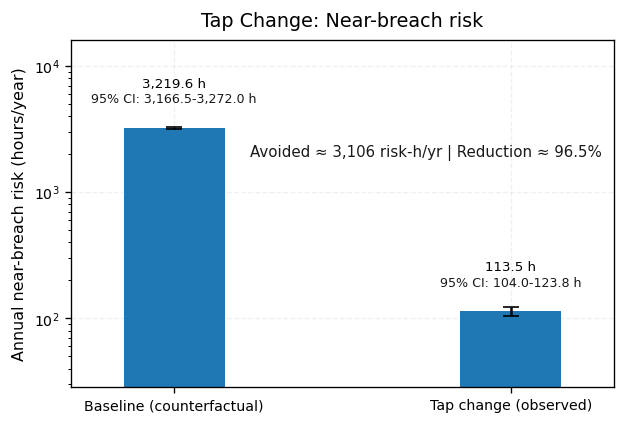

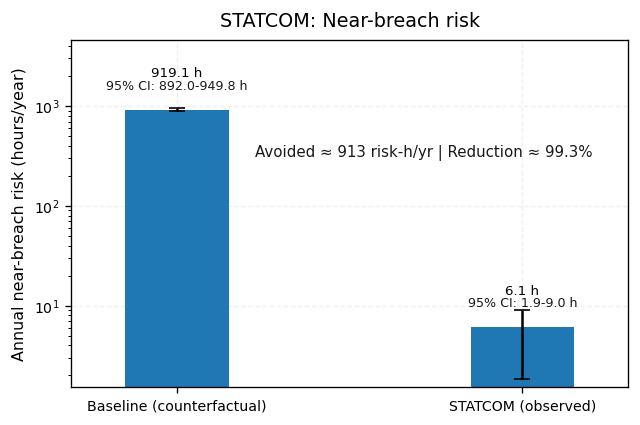

In [ ]:
# @title
# 6) Counterfactual vs observed (Year-2) near-breach risk (hours/year)
for _, r in cb_df.iterrows():
    asset = r["asset"]
    option = r["option"]

    labels = ["Baseline (counterfactual)", f"{option} (observed)"]

    v0 = float(r["counterfactual_baseline_ann_risk_min"]) / 60.0
    v1 = float(r["observed_after_ann_risk_min"]) / 60.0
    vals = [v0, v1]

    # 95% CI bounds (hours)
    ci0_lo = float(r["counterfactual_CI_low"]) / 60.0
    ci0_hi = float(r["counterfactual_CI_high"]) / 60.0
    ci1_lo = float(r["after_CI_low"]) / 60.0
    ci1_hi = float(r["after_CI_high"]) / 60.0

    # asymmetric error bars in HOURS
    yerr = [
        [v0 - ci0_lo, v1 - ci1_lo],
        [ci0_hi - v0, ci1_hi - v1],
    ]

    avoided_hr = float(r["avoided_ann_risk_hr"])
    pct_red = 100.0 * avoided_hr / max(v0, 1e-9)

    fig, ax = plt.subplots(figsize=(5.4, 3.6))
    x = np.arange(len(labels))

    bars = ax.bar(
        x, vals,
        yerr=yerr,
        capsize=5,
        width=0.3,
        linewidth=0.8
    )

    ax.set_yscale("log")

    ymin = max(0.5, min(vals) / 4.0)
    ymax = max(vals) * 5.0
    ax.set_ylim(ymin, ymax)

    ax.set_title(f"{asset}: Near-breach risk", pad=8)

    ax.text(
        0.33, 0.7,
        f"Avoided ≈ {avoided_hr:,.0f} risk-h/yr | Reduction ≈ {pct_red:.1f}%",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=9,
        alpha=0.9
    )

    ax.set_ylabel("Annual near-breach risk (hours/year)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, axis="y", alpha=0.18, linestyle="--")
    ax.set_axisbelow(True)

    ci_pairs = [(ci0_lo, ci0_hi), (ci1_lo, ci1_hi)]
    for b, v, (lo, hi) in zip(bars, vals, ci_pairs):
        # value label
        ax.text(
            b.get_x() + b.get_width()/2,
            v * 2,
            f"{v:,.1f} h",
            ha="center", va="bottom",
            fontsize=8
        )
        # CI label (slightly above the value label)
        ax.text(
            b.get_x() + b.get_width()/2,
            v * 1.5,
            f"95% CI: {lo:,.1f}-{hi:,.1f} h",
            ha="center", va="bottom",
            fontsize=7.6,
            alpha=0.9
        )

    ax.margins(x=0.12)
    plt.tight_layout()
    plt.show()


## Counterfactual vs Observed Outcomes

These plots compare:
- **Baseline (counterfactual)**: predicted Year-2 near-breach risk if no intervention had occurred.
- **Observed after**: measured Year-2 near-breach risk after the intervention was applied.

### How to interpret the gap
- A large reduction from counterfactual to observed indicates the intervention likely reduced risk under the same Year-2 operating conditions.
- The 95% CI bars communicate planning uncertainty (day-block bootstrap).

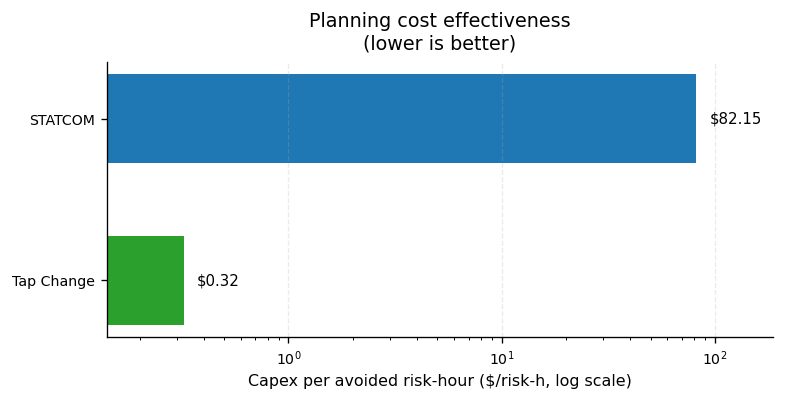

In [ ]:
# @title
# 7) Cost effectiveness (capex per avoided risk-hour)
# Improved: clearer hierarchy, better spacing, exec-ready styling

plot_df = cb_df.copy()
plot_df["label"] = plot_df["asset"]
plot_df = (
    plot_df
    .dropna(subset=["capex_per_avoided_risk_hr_$"])
    .sort_values("capex_per_avoided_risk_hr_$", ascending=True)
)

fig, ax = plt.subplots(figsize=(6.6, 3.4))

# Colour logic: cheapest = green, others = neutral blue
colors = ["#2ca02c"] + ["#1f77b4"] * (len(plot_df) - 1)

bars = ax.barh(
    plot_df["label"],
    plot_df["capex_per_avoided_risk_hr_$"],
    color=colors,
    height=0.55
)

# Log scale (essential here)
ax.set_xscale("log")
ax.set_xlabel("Capex per avoided risk-hour ($/risk-h, log scale)")
ax.set_title("Planning cost effectiveness\n(lower is better)", pad=8)

# Cleaner grid (x only)
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")

# Value labels — aligned and readable
for bar, val in zip(bars, plot_df["capex_per_avoided_risk_hr_$"]):
    ax.text(
        val * 1.15,
        bar.get_y() + bar.get_height() / 2,
        f"${val:,.2f}",
        va="center",
        ha="left",
        fontsize=9
    )

# Improve margins and remove clutter
ax.margins(x=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


## Cost Effectiveness

Capex per avoided risk-hour = `capex_$ / avoided_ann_risk_hr`

- Lower values indicate better capital efficiency for reducing near‑breach exposure.

### Decision rule
Cost efficiency is necessary but not sufficient. We also check whether residual risk exceeds the planning target:
- If post-intervention risk remains above target (considering uncertainty), the tool flags that reconductoring/augmentation may still be required.

This prevents “cheap but insufficient” options from being incorrectly recommended.


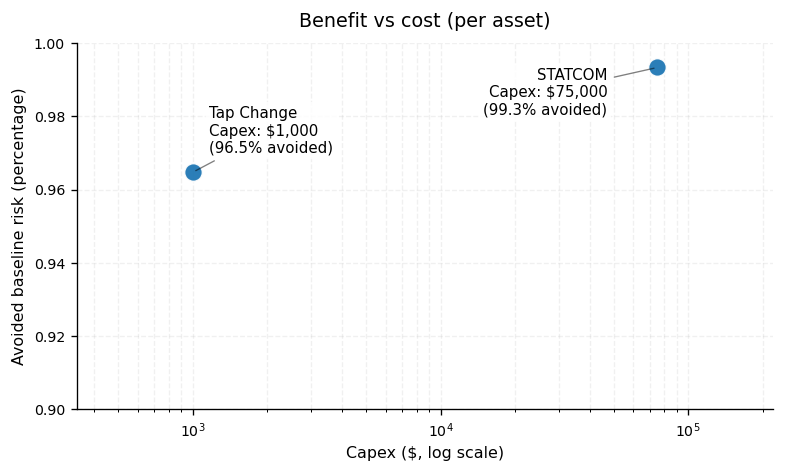

In [ ]:
# @title
# 8) Benefit vs cost (asset-level overview)
# Normalised y-axis: fraction of baseline risk avoided

plot_df = cb_df.copy()
plot_df["label"] = plot_df["asset"]

# Convert baseline minutes -> hours for normalisation
plot_df["cf_risk_hr"] = plot_df["counterfactual_baseline_ann_risk_min"] / 60.0

# Normalised avoided risk (0..1)
plot_df["avoided_frac"] = (
    plot_df["avoided_ann_risk_hr"] / plot_df["cf_risk_hr"].replace(0, np.nan)
)

# (optional) efficiency for label context
plot_df["eff_hr_per_$"] = plot_df["avoided_ann_risk_hr"] / plot_df["capex_$"].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(6.6, 4.0))

x = plot_df["capex_$"].astype(float).to_numpy()
y = plot_df["avoided_frac"].astype(float).to_numpy()

ax.scatter(x, y, s=120, edgecolors="white", linewidths=1.2, alpha=0.95)

# log x so low and high capex show together
ax.set_xscale("log")
ax.set_xlabel("Capex ($, log scale)")
ax.set_ylabel("Avoided baseline risk (percentage)")
ax.set_title("Benefit vs cost (per asset)", pad=10)

# y-axis bounds for interpretability
ax.set_ylim(0.9, 1.0)

# grid + clean frame
ax.grid(True, which="both", axis="both", alpha=0.18)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Label placement
x_med = np.nanmedian(x)

for _, r in plot_df.iterrows():
    xi = float(r["capex_$"])
    yi = float(r["avoided_frac"])

    if xi >= x_med:
        xytext = (-30, -30)
        ha = "right"
    else:
        xytext = (10, 10)
        ha = "left"

    capex_txt = f"${xi:,.0f}"
    ax.annotate(
        f"{r['label']}\nCapex: {capex_txt}\n({yi:.1%} avoided)",
        (xi, yi),
        textcoords="offset points",
        xytext=xytext,
        ha=ha, va="bottom",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85),
        arrowprops=dict(arrowstyle="-", lw=0.8, alpha=0.5)
    )


ax.margins(x=0.25, y=0.20)

plt.tight_layout()
plt.show()


## Benefit vs Cost (Per Asset)

This chart positions each option by:
- X-axis: capex ($)  
- Y-axis: fraction of counterfactual baseline risk avoided (0-1)

For investment justification, this is paired with sensitivity analysis which gives the probability of positive ROI under uncertainty (using the counterfactual vs observed CI bands).


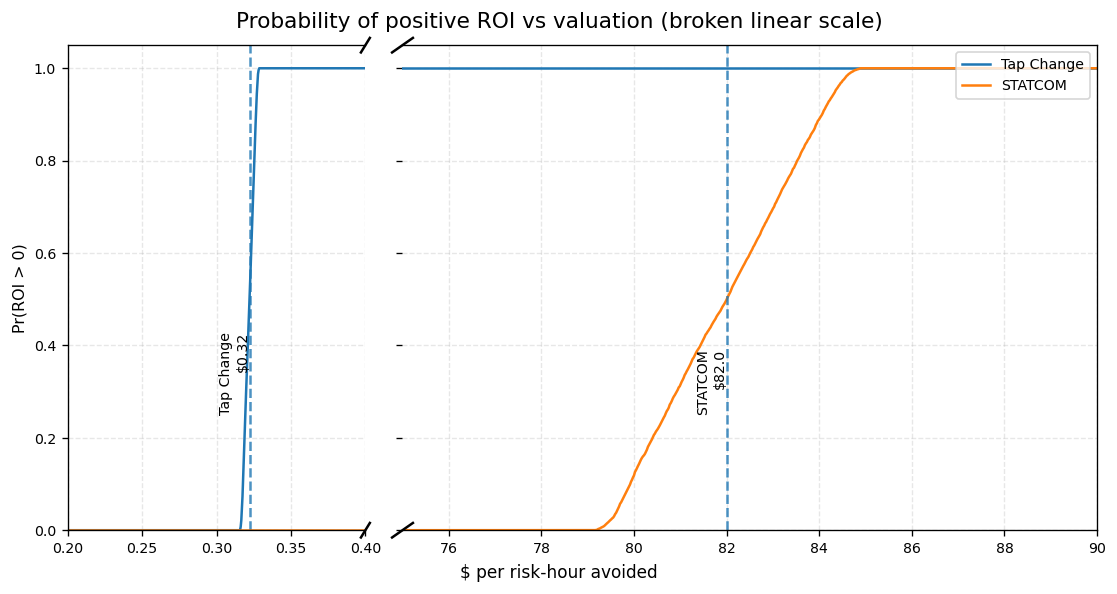

Tap Change: break-even median=0.32 $/risk-hour (5–95%=0.32–0.33), capex=$1000
STATCOM: break-even median=82.00 $/risk-hour (5–95%=79.67–84.35), capex=$75000


In [ ]:
# @title
# ROI sensitivity — broken x-axis (linear): 0.2–0.4, break, 75–90
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------
def sample_avoided_hours(cf_lo, cf_hi, after_lo, after_hi, n=6000, seed=7):
    rng = np.random.default_rng(seed)
    cf = rng.uniform(cf_lo, cf_hi, size=n)
    af = rng.uniform(after_lo, after_hi, size=n)
    avoided_min = cf - af
    return avoided_min / 60.0  # hours

def pr_roi_positive(value_grid: np.ndarray, capex: float, avoided_hr_samples: np.ndarray):
    return np.array([float(np.mean(avoided_hr_samples * v > capex)) for v in value_grid])

def fmt_money(x: float) -> str:
    if not np.isfinite(x):
        return "NA"
    if x < 1:
        return f"${x:.2f}"
    if x < 100:
        return f"${x:.1f}"
    return f"${x:.0f}"

CAPEX_OPERATIONAL_THRESHOLD = 1.0

# ----------------------------
# Build break-even summary + distributions
# ----------------------------
rows = []
dist = {}

for _, r in cb_df.iterrows():
    asset = r["asset"]
    capex = float(r["capex_$"])

    avoided_samples = sample_avoided_hours(
        r["counterfactual_CI_low"], r["counterfactual_CI_high"],
        r["after_CI_low"], r["after_CI_high"],
        n=6000, seed=7
    )
    avoided_samples = avoided_samples[np.isfinite(avoided_samples)]
    dist[asset] = (capex, avoided_samples)

    ok = avoided_samples > 0
    if ok.mean() < 0.05:
        rows.append({
            "asset": asset,
            "capex_$": capex,
            "break_even_p05": np.nan,
            "break_even_p50": np.nan,
            "break_even_p95": np.nan,
        })
        continue

    if capex <= CAPEX_OPERATIONAL_THRESHOLD:
        be_samples = np.zeros(ok.sum())
    else:
        be_samples = capex / avoided_samples[ok]

    p05, p50, p95 = np.percentile(be_samples, [5, 50, 95])
    rows.append({
        "asset": asset,
        "capex_$": capex,
        "break_even_p05": float(p05),
        "break_even_p50": float(p50),
        "break_even_p95": float(p95),
    })

be_df = pd.DataFrame(rows)

# ----------------------------
# Broken x-axis plot: [0.2, 0.4] then [75, 90]
# ----------------------------
x1_lo, x1_hi = 0.2, 0.4
x2_lo, x2_hi = 75.0, 90.0

x1 = np.linspace(x1_lo, x1_hi, 500)
x2 = np.linspace(x2_lo, x2_hi, 700)

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, figsize=(9.2, 4.4),
    gridspec_kw={"width_ratios": [1.2, 2.8]},
    layout="constrained"
)

# --- label height (make the vertical annotations higher) ---
LABEL_Y = 0.25

for asset, (capex, avoided_samples) in dist.items():

    if capex <= CAPEX_OPERATIONAL_THRESHOLD:
        ax1.plot(x1, np.ones_like(x1), label=f"{asset}")
        ax2.plot(x2, np.ones_like(x2))
    else:
        ax1.plot(x1, pr_roi_positive(x1, capex, avoided_samples), label=asset)
        ax2.plot(x2, pr_roi_positive(x2, capex, avoided_samples))

    # Annotate median break-even
    be50 = be_df.loc[be_df["asset"] == asset, "break_even_p50"].iloc[0]
    if np.isfinite(be50):
        if x1_lo <= be50 <= x1_hi:
            ax1.axvline(be50, linestyle="--", alpha=0.8)
            ax1.text(
                be50, LABEL_Y, f"{asset}\n{fmt_money(be50)}",
                rotation=90, ha="right", va="bottom"
            )
        elif x2_lo <= be50 <= x2_hi:
            ax2.axvline(be50, linestyle="--", alpha=0.8)
            ax2.text(
                be50, LABEL_Y, f"{asset}\n{fmt_money(be50)}",
                rotation=90, ha="right", va="bottom"
            )

# Limits
ax1.set_xlim(x1_lo, x1_hi)
ax2.set_xlim(x2_lo, x2_hi)
ax1.set_ylim(0, 1.05)

# Y label (left only)
ax1.set_ylabel("Pr(ROI > 0)")

# Centered X label across both panels
fig.supxlabel(
    "$ per risk-hour avoided",
    y=-0.04  # push below axes
)

# Centered title
fig.suptitle(
    "Probability of positive ROI vs valuation (broken linear scale)",
    fontsize=13,
    y=1.04  # push above the axes
)

# Grid
ax1.grid(True, alpha=0.3)
ax2.grid(True, alpha=0.3)

# Broken-axis marks
d = 0.015
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs = dict(transform=ax2.transAxes, color="k", clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# Clean spines / ticks
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.tick_params(labelleft=False)

# Legend on SECOND panel (top-right)
handles, labels = ax1.get_legend_handles_labels()
ax2.legend(handles, labels, loc="upper right", frameon=True)

plt.show()

# ----------------------------
# Numeric summary
# ----------------------------
for _, r in be_df.sort_values("break_even_p50", ascending=True).iterrows():
    if np.isfinite(r["break_even_p50"]):
        print(
            f"{r['asset']}: break-even median={r['break_even_p50']:.2f} $/risk-hour "
            f"(5–95%={r['break_even_p05']:.2f}-{r['break_even_p95']:.2f}), capex=${r['capex_$']:.0f}"
        )
    else:
        print(f"{r['asset']}: break-even undefined (avoided risk not consistently positive)")


### ROI results for PV-driven voltage management

This shows how likely each option is to deliver **positive ROI** as a function of how much avoided voltage risk (from PV export and load variability) is valued.

**Tap Change (operational control)**  
- **Break-even ≈ \$0.32 per risk-hour**.  
- ROI is positive for essentially any non-zero valuation of avoided risk.  
- Reflects that small tap adjustments significantly reduce PV-driven overvoltage and load-driven voltage swings at negligible cost.  

**STATCOM (capital intervention)**  
- **Break-even ≈ \$82 per risk-hour** (5-95%: ~\$80-\$84).  
- Below this threshold, ROI is unlikely; above it, ROI is almost certain.  
- Indicates STATCOMs are only justified where residual voltage risk remains high after operational controls (e.g. high PV penetration, rapid ramps, weak feeders).  

**Overall implication**  
This PV and load-driven voltage issue can be addressed cost-effectively with operational settings. Capital assets like STATCOMs should be reserved for feeders where avoided non-compliance hours carry high economic or regulatory value.


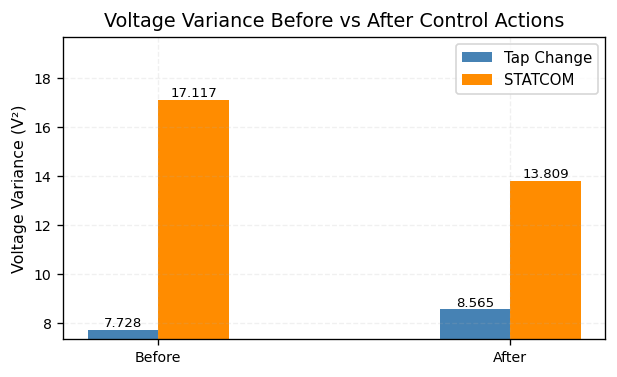

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

VOLTAGE_COL = "voltage"
BAR_WIDTH = 0.2

# Compute raw variance (V^2)
tap_before  = dfs["tap_y1"][VOLTAGE_COL].var()
tap_after   = dfs["tap_y2"][VOLTAGE_COL].var()
stat_before = dfs["stat_y1"][VOLTAGE_COL].var()
stat_after  = dfs["stat_y2"][VOLTAGE_COL].var()

tap_vals  = [tap_before, tap_after]
stat_vals = [stat_before, stat_after]

# X positions
x = np.arange(2)  # Before, After

# Manual Y-LIMIT
all_vals = tap_vals + stat_vals
y_min = 0.95 * min(all_vals)
y_max = 1.15 * max(all_vals)
Y_LIM = (y_min, y_max)

plt.figure(figsize=(5.2, 3.2))

bars_tap = plt.bar(
    x - BAR_WIDTH/2, tap_vals,
    width=BAR_WIDTH, color="steelblue", label="Tap Change"
)

bars_stat = plt.bar(
    x + BAR_WIDTH/2, stat_vals,
    width=BAR_WIDTH, color="darkorange", label="STATCOM"
)

plt.xticks(x, ["Before", "After"])
plt.ylabel("Voltage Variance (V²)")
plt.title("Voltage Variance Before vs After Control Actions")
plt.ylim(Y_LIM)
plt.legend(fontsize=9)

def label_bars(bars, fmt="{:.3f}"):
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            fmt.format(h),
            ha="center",
            va="bottom",
            fontsize=8
        )

label_bars(bars_tap)
label_bars(bars_stat)

plt.tight_layout()
plt.show()


### Interpretation of Voltage Variance Results

Variance isolates short-term volatility, which is often what PV injections and load ramps worsen.

- **STATCOM:**  
  - Reduces variance after deployment, consistent with fast reactive support that damps voltage swings.  
  - This addresses PV-driven intermittency (cloud edges) and rapid load changes.

- **Tap change:**  
  - Primarily shifts the voltage level to address persistent over/undervoltage.  
  - Typically has limited impact on variance, because it does not respond continuously to short-term fluctuations.

Tap is a level-set control. STATCOM is a volatility/ramp control.


## Model Limitations

### 1) Statistical model, not power-flow physics
- The approach learns from data; it does not explicitly model feeder impedance, phase coupling, or voltage propagation.
- Results are therefore suitable for planning and option ranking, not protection design or real-time control.

### 2) Counterfactual assumes structural stability
- The Year-1 relationship between operating conditions and risk is assumed to remain broadly valid in Year-2.
- Material topology changes, customer mix shifts, inverter setting changes, or measurement changes can weaken this assumption.
- Drift checks help flag lower-confidence cases.

### 3) Uncertainty is statistical, not worst-case engineering bounds
- Bootstrap CIs capture sampling variability and day-to-day variation, but not all engineering uncertainties (extreme events, coordinated behaviour).

---


## Future Improvements and Extensions

- **Incorporate power-system context features**  
  Add feeder-level electrical proxies (e.g. impedance class, X/R ratio bands, distance-to-transformer, phase loading imbalance) to partially bridge the gap between statistical learning and power-flow physics.

- **Explicit PV and load dynamics**  
  Include ramp rates, net export duration, coincidence of PV peaks with low load, and volatility metrics to better capture conditions that drive voltage excursions.

- **Regime-aware modelling**  
  Introduce drift-triggered retraining or regime segmentation (e.g. pre/post inverter setting changes, seasonal PV regimes) rather than assuming full structural stability year-to-year.

- **Scenario-based stress testing**  
  Augment bootstrap uncertainty with synthetic “stress days” representing extreme PV output, heatwave load, or coordinated inverter behaviour to approximate worst-case risk.

- **Asset-aware cost modelling**  
  Refine cost inputs by incorporating asset lifetime, maintenance, and degradation, enabling multi-year NPV comparisons rather than single-year break-even analysis.
